In [6]:
pip install numpy==1.23.5

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install scikit-surprise==1.1.0

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [21]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


### Load the dataset and add the decade column by performing a join operation.

In [22]:
# Define the path to your local dataset directory
dataset_path = "../data/ml-100k"

# Load ratings data (assumes the file is 'u.data' in the ml-100k folder)
df_ratings = pd.read_csv(f"{dataset_path}/u.data", sep='\t', header=None, 
                         names=['user_id', 'item_id', 'rating', 'timestamp'])

# Convert item_id to integer
df_ratings['item_id'] = df_ratings['item_id'].astype(int)

# Define movie metadata columns based on u.item structure
movie_columns = ['item_id', 'movie_title', 'release_date', 'video_release_date', 'IMDb_URL',
                 'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime',
                 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery',
                 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

# Load movie metadata from local u.item file
df_movies = pd.read_csv(f"{dataset_path}/u.item", sep='|', encoding='latin-1',
                        names=movie_columns, usecols=['item_id', 'release_date'])

# Convert item_id in df_movies to int
df_movies['item_id'] = df_movies['item_id'].astype(int)

# Merge ratings with movie release dates
df_final = pd.merge(df_ratings, df_movies, on='item_id', how='left')

# Drop timestamp as it's not needed
df_final.drop(columns=['timestamp'], inplace=True)

# Convert release_date to datetime, handling missing values
df_final['release_date'] = pd.to_datetime(df_final['release_date'], errors='coerce')

# Extract the year from release_date
df_final['year'] = df_final['release_date'].dt.year

# Create a new column 'decade' by rounding down the year to the nearest decade
df_final['decade'] = (df_final['year'] // 10) * 10

# Drop the 'year' and 'release_date' columns as they're no longer needed
df_final.drop(columns=['year', 'release_date'], inplace=True)

# Display the first few rows of the final DataFrame
print(df_final.head())


   user_id  item_id  rating  decade
0      196      242       3  1990.0
1      186      302       3  1990.0
2       22      377       1  1990.0
3      244       51       2  1990.0
4      166      346       1  1990.0


In [10]:
# Save the df_final dataset as a CSV file in the current directory
df_final.to_csv("../preprocessing/df_final.csv", index=False)

### Data analyis

In [26]:
# Select 10 random unique users from the dataset
random_users = np.random.choice(df_final['user_id'].unique(), 200, replace=False)

# Count how many movies each user watched
user_movie_counts = df_final[df_final['user_id'].isin(random_users)].groupby('user_id')['item_id'].count()

# Convert to DataFrame for better display
df_final_user_movie_counts = user_movie_counts.reset_index()
df_final_user_movie_counts.columns = ['user_id', '# movies watched']

# Display the result
print("Random Users Movie Count:")
print(df_final_user_movie_counts.max())

Random Users Movie Count:
user_id             936
# movies watched    490
dtype: int64


In [29]:
# Count how many movies each user watched in the entire dataset
user_movie_counts_all = df_final.groupby('user_id')['item_id'].count()

# Get the maximum count of movies rated by any user in the entire dataset
max_movie_count_all = user_movie_counts_all.max()
min_movie_count_all = user_movie_counts_all.min()
print("Maximum number of movies watched by any user in the entire dataset:", max_movie_count_all)
print("Minimum number of movies watched by any user in the entire dataset:", min_movie_count_all)


Maximum number of movies watched by any user in the entire dataset: 737
Minimum number of movies watched by any user in the entire dataset: 20


Counting Movies Per Decade

In [53]:
# Extract unique decades
unique_decades = df_final['decade'].dropna().unique()
unique_user_ids = df_final['user_id'].nunique()

# len(unique_user_ids)  # or
# df_final['user_id'].nunique()

# Extract unique item_ids and count total movies
existing_item_ids = df_final['item_id'].unique()
total_movies = df_final['item_id'].nunique()

# Extract the last user ID in df_final and define a starting point for new users
max_existing_user_id = df_final['user_id'].max()
#min_existing_user_id = df_final['user_id'].min()
num_new_users = 40
new_user_start_id = max_existing_user_id + 1

# Count movies per decade
movies_per_decade = df_final.groupby('decade')['item_id'].nunique().reset_index(name='movie_count')
print("Unique Decades Available:", unique_decades)
print("Unique User IDs:", unique_user_ids)
print("Total Unique Movies Available:", total_movies)
print("Starting User ID for New Users:", new_user_start_id)
print("\nMovies Per Decade:")
print(movies_per_decade)
print("\n")
print("Columns:", df_final.columns)

Unique Decades Available: [1990. 1960. 1970. 1950. 1980. 1940. 1930. 1920.]
Unique User IDs: 943
Total Unique Movies Available: 1682
Starting User ID for New Users: 944

Movies Per Decade:
   decade  movie_count
0  1920.0            2
1  1930.0           29
2  1940.0           45
3  1950.0           54
4  1960.0           43
5  1970.0           53
6  1980.0          107
7  1990.0         1348


Columns: Index(['user_id', 'item_id', 'rating', 'decade'], dtype='object')


## Computation of user-decade diversity and clustering

In [14]:
# Step 1: Count number of ratings per user per decade
user_decade_counts = df_final.groupby(['user_id', 'decade']).size().unstack(fill_value=0)

# Step 2: Normalize counts so each user's row sums to 1
user_decade_normalized = user_decade_counts.div(user_decade_counts.sum(axis=1), axis=0)

# Step 3: Rename columns to indicate normalization
user_decade_normalized.columns = [f'{int(c)}_norm' for c in user_decade_normalized.columns]

# Step 4: Merge raw counts with normalized values
user_decade_merged = pd.concat([user_decade_counts, user_decade_normalized], axis=1).reset_index()

# Step 5: Preview the result
#print(user_decade_merged.head())
user_decade_merged


,user_id,1920.0,1930.0,1940.0,1950.0,1960.0,1970.0,1980.0,1990.0,1920_norm,1930_norm,1940_norm,1950_norm,1960_norm,1970_norm,1980_norm,1990_norm
0,1,0,4,1,3,9,18,44,192,0.0,0.014760,0.003690,0.011070,0.033210,0.066421,0.162362,0.708487
1,2,0,0,0,0,0,2,0,60,0.0,0.000000,0.000000,0.000000,0.000000,0.032258,0.000000,0.967742
2,3,0,0,0,0,0,0,0,54,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
3,4,0,0,0,0,0,2,1,21,0.0,0.000000,0.000000,0.000000,0.000000,0.083333,0.041667,0.875000
4,5,0,2,3,6,9,20,32,102,0.0,0.011494,0.017241,0.034483,0.051724,0.114943,0.183908,0.586207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
938,939,0,0,0,0,0,1,0,48,0.0,0.000000,0.000000,0.000000,0.000000,0.020408,0.000000,0.979592
939,940,0,1,0,3,3,8,28,64,0.0,0.009346,0.000000,0.028037,0.028037,0.074766,0.261682,0.598131
940,941,0,0,0,0,0,0,0,22,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
941,942,0,3,7,6,9,5,11,38,0.0,0.037975,0.088608,0.075949,0.113924,0.063291,0.139241,0.481013


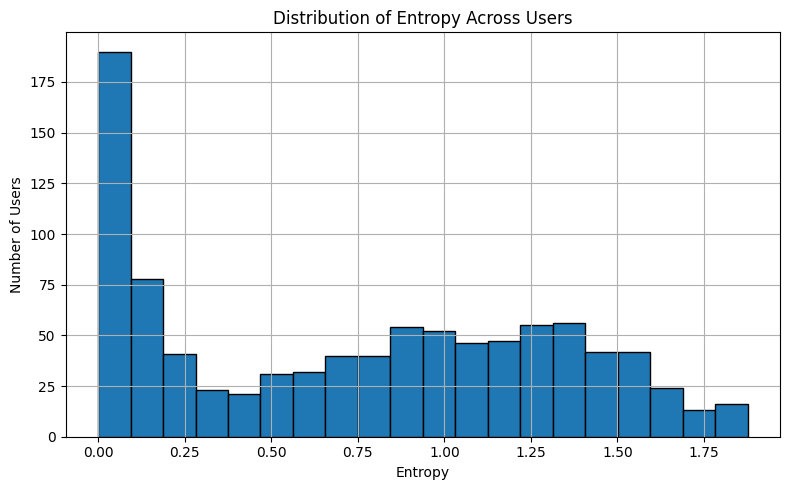

In [ ]:
# ===== Step 1: Count how many movies each user rated in each decade =====
user_decade_counts = df_final.groupby(['user_id', 'decade']).size().unstack(fill_value=0)

# ===== Step 2: Normalize the counts so each user's row sums to 1 (i.e., distribution over decades) =====
user_decade_normalized = user_decade_counts.div(user_decade_counts.sum(axis=1), axis=0)
user_decade_normalized.columns = [f'{int(c)}_norm' for c in user_decade_normalized.columns]

# ===== Step 3: Calculate entropy for each user to measure diversity of preferences =====
user_entropy = user_decade_normalized.apply(lambda x: entropy(x), axis=1).to_frame(name='entropy')
user_entropy.reset_index(inplace=True)

# ===== Step 4a: Quantile-Based Clustering =====
user_entropy_quantile = user_entropy.copy()
n_users = len(user_entropy_quantile)
user_entropy_quantile['cluster'] = pd.cut(
    user_entropy_quantile.index.sort_values(),
    bins=[-1, n_users // 3, 2 * n_users // 3, n_users],
    labels=[0, 1, 2]
).astype(int)

user_entropy.to_csv("../preprocessing/user_entropy.csv", index=False)

# ===== Step 4b: KMeans Clustering =====
user_entropy_kmeans = user_entropy.copy()
kmeans = KMeans(n_clusters=3, random_state=42)
user_entropy_kmeans['cluster'] = kmeans.fit_predict(user_entropy_kmeans[['entropy']])
cluster_order = user_entropy_kmeans.groupby('cluster')['entropy'].mean().sort_values().index
entropy_cluster_map = {old: new for new, old in enumerate(cluster_order)}
user_entropy_kmeans['cluster'] = user_entropy_kmeans['cluster'].map(entropy_cluster_map)

# ===== Step 5: Merge both clustering results with original counts =====
merged_quantile = pd.merge(user_decade_counts.reset_index(), user_entropy_quantile, on='user_id')
merged_kmeans = pd.merge(user_decade_counts.reset_index(), user_entropy_kmeans, on='user_id')

# ===== Step 6: Sort by cluster before saving =====
merged_quantile_sorted = merged_quantile.sort_values(by='cluster')

# ===== Step 7: Save both sorted DataFrames =====
merged_quantile_sorted.to_csv("user_clusters_quantile.csv", index=False)



# Plot histogram of entropy values
plt.figure(figsize=(8, 5))
plt.hist(merged_result_with_cluster['entropy'], bins=20, edgecolor='black')
plt.title('Distribution of Entropy Across Users')
plt.xlabel('Entropy')
plt.ylabel('Number of Users')
plt.grid(True)
plt.tight_layout()
plt.show()


In [16]:


# ===== Step 1: Count how many movies each user rated in each decade =====
user_decade_counts = df_final.groupby(['user_id', 'decade']).size().unstack(fill_value=0)

# ===== Step 2: Normalize the counts so each user's row sums to 1 (i.e., distribution over decades) =====
user_decade_normalized = user_decade_counts.div(user_decade_counts.sum(axis=1), axis=0)
user_decade_normalized.columns = [f'{int(c)}_norm' for c in user_decade_normalized.columns]

# ===== Step 3: Combine raw counts and normalized values into one DataFrame =====
user_decade_merged = pd.concat([user_decade_counts, user_decade_normalized], axis=1).reset_index()

# ===== Step 4: Calculate entropy for each user to measure diversity of preferences across decades =====
user_entropy = user_decade_normalized.apply(lambda x: entropy(x), axis=1).to_frame(name='entropy')
user_entropy.reset_index(inplace=True)

# ===== Step 5: Sort users by entropy and assign quantile-based clusters =====
user_entropy_sorted = user_entropy.sort_values(by='entropy').reset_index(drop=True)
n_users = len(user_entropy_sorted)

# Assign cluster based on position
user_entropy_sorted['cluster'] = pd.cut(
    user_entropy_sorted.index,
    bins=[-1, n_users // 3, 2 * n_users // 3, n_users],
    labels=[0, 1, 2]
).astype(int)

# ===== Step 6: Merge decade counts with entropy and cluster assignments =====
merged_result_with_cluster = pd.merge(
    user_decade_counts.reset_index(),  # raw decade counts
    user_entropy_sorted[['user_id', 'entropy', 'cluster']],  # entropy + cluster
    on='user_id'
)

# ===== Step 7: Sort final result by entropy for inspection =====
merged_result_with_user = merged_result_with_cluster.sort_values(by='entropy')

# Optional: Save or inspect
merged_result_with_user.to_csv("user_user_clusters_quantile.csv", index=False)

# # Display preview
merged_result_with_user.head()

,user_id,1920.0,1930.0,1940.0,1950.0,1960.0,1970.0,1980.0,1990.0,entropy,cluster
543,544,0,0,0,0,0,0,0,31,0.0,0
800,801,0,0,0,0,0,0,0,26,0.0,0
204,205,0,0,0,0,0,0,0,22,0.0,0
205,206,0,0,0,0,0,0,0,64,0.0,0
571,572,0,0,0,0,0,0,0,20,0.0,0


user segmentation based on rating diversity across movie decades.

In [56]:
merged_quantile_sorted[merged_quantile_sorted['user_id'] == 568]

,user_id,1920.0,1930.0,1940.0,1950.0,1960.0,1970.0,1980.0,1990.0,entropy,cluster
567,568,0,12,10,11,10,6,10,22,1.8756,1


In [ ]:
# Get the row with the maximum entropy
user_entropy.loc[user_entropy['entropy'].idxmax()]


user_id    568.0000
entropy      1.8756
Name: 567, dtype: float64

In [ ]:
# Step 1: Find row with maximum entropy
max_row = quantile_df.loc[quantile_df['entropy'].idxmax()]
print("🔺 Max Entropy:")
print(f"Entropy: {max_row['entropy']:.4f}, User ID: {max_row['user_id']}, Cluster: {max_row['cluster']}")

# Step 2: Find row with minimum entropy
min_row = quantile_df.loc[quantile_df['entropy'].idxmin()]
print("\n🔻 Min Entropy:")
print(f"Entropy: {min_row['entropy']:.4f}, User ID: {min_row['user_id']}, Cluster: {min_row['cluster']}")

# Step 3: Create df_cluster with only user_id and cluster
df_cluster = quantile_df[['user_id', 'cluster']].copy()


🔺 Max Entropy:
Entropy: 1.8756, User ID: 568.0, Cluster: 2.0

🔻 Min Entropy:
Entropy: 0.0000, User ID: 544.0, Cluster: 0.0


In [ ]:
quantile_df

In [ ]:
# Keep only user_id and cluster columns
df_cluster = quantile_df[['user_id', 'cluster','entropy']].copy()

# Save to CSV in the current working directory
df_cluster.to_csv("df_cluster.csv", index=False)

print("✅ df_cluster.csv saved successfully.")


✅ df_cluster.csv saved successfully.


In [ ]:
# Assuming your original DataFrame is called df

cluster0 = df_cluster[df_cluster['cluster'] == 0]
cluster1 = df_cluster[df_cluster['cluster'] == 1]
cluster2 = df_cluster[df_cluster['cluster'] == 2]
cluster0.to_csv("../preprocessing/cluster_0_users.csv", index=False)
cluster1.to_csv("../preprocessing/cluster_1_users.csv", index=False)
cluster2.to_csv("../preprocessing/cluster_2_users.csv", index=False)

In [ ]:
cluster0

,user_id,cluster,entropy
0,544,0,0.000000
1,801,0,0.000000
2,205,0,0.000000
3,206,0,0.000000
4,572,0,0.000000
...,...,...,...
310,736,0,0.286836
311,443,0,0.286836
312,649,0,0.286836
313,223,0,0.290457


In [ ]:
quantile_df

,user_id,1920.0,1930.0,1940.0,1950.0,1960.0,1970.0,1980.0,1990.0,entropy,cluster
0,544,0,0,0,0,0,0,0,31,0.000000,0
1,801,0,0,0,0,0,0,0,26,0.000000,0
2,205,0,0,0,0,0,0,0,22,0.000000,0
3,206,0,0,0,0,0,0,0,64,0.000000,0
4,572,0,0,0,0,0,0,0,20,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...
938,553,0,8,13,20,16,5,14,24,1.849938,2
939,312,1,19,24,33,20,22,36,68,1.858054,2
940,338,0,6,8,9,10,9,11,22,1.859598,2
941,426,0,13,24,23,14,9,8,10,1.861485,2
